In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install -q timm

In [3]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

In [4]:
INPUT_PATH  = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
# INPUT_PATH  = '/content/drive/My Drive/Kaggle/rsna-2024-lumbar-spine-degenerative-classification'
# INPUT_PATH  = '/Users/star-bits/Downloads/rsna-2024-lumbar-spine-degenerative-classification'
OUTPUT_PATH = '/kaggle/working'
# OUTPUT_PATH = '/content/drive/My Drive/Kaggle/rsna-2024-lsdc-train'
# OUTPUT_PATH = '/Users/star-bits/Downloads/rsna-2024-lsdc-train'

In [5]:
# Add Input -> Your Work + Notebook -> rsna24lsdc_0815_eda_dcm2png
PNG_PATH = '/kaggle/input/rsna24lsdc-0815-eda-dcm2png'

In [6]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count()
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 40
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 20 if NOT_DEBUG else 2
MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

In [7]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

In [8]:
df = pd.read_csv(f'{INPUT_PATH}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [9]:
df = df.fillna(-100)

label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_34/3645280688.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
# 예외처리 할 study_id들 제거

print(len(df))

study_ids_to_remove = [3008676218, 2780132468, 2492114990]
df = df[~df['study_id'].isin(study_ids_to_remove)]

print(len(df))

1975
1972


In [11]:
CONDITIONS = [
    'Spinal Canal Stenosis',
    'Left Neural Foraminal Narrowing',
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

In [12]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)

        # Sagittal T1
        for i in range(10):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Sagittal T1/{i+1:02d}.png'
                img = Image.open(img_path).convert('L') # single channel gray scale - luminance
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T1')

        # Sagittal T2/STIR
        for i in range(10):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Sagittal T2_STIR/{i+1:02d}.png'
                img = Image.open(img_path).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T2/STIR')

        # Axial T2
        for i in range(20):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Axial T2/{i+1:02d}.png'
                img = Image.open(img_path).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Axial T2')

        if self.transform is not None:
            x = self.transform(image=x)['image']
        x = x.transpose(2, 0, 1)

        return x, label

In [13]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=(3, 5)),  # Changed from blur_limit=5 to (3, 5)
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

Sample 1:
Input tensor shape: torch.Size([1, 40, 512, 512])
Input tensor stats - Min: -1.00, Max: 0.97, Mean: -0.53, Std: 0.37
Target: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]), Shape: torch.Size([1, 25])


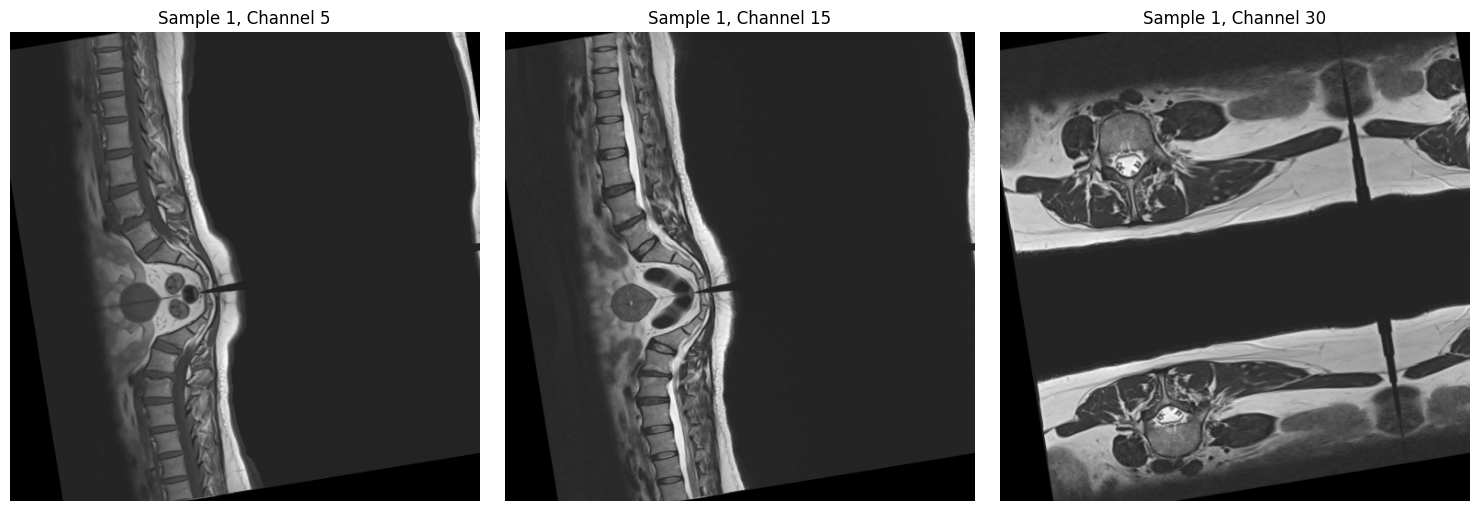

Channel 5 stats - Min: -1.00, Max: 0.89, Mean: -0.63, Std: 0.29
Channel 15 stats - Min: -1.00, Max: 0.84, Mean: -0.61, Std: 0.32
Channel 30 stats - Min: -1.00, Max: 0.85, Mean: -0.43, Std: 0.42

Sample 2:
Input tensor shape: torch.Size([1, 40, 512, 512])
Input tensor stats - Min: -1.00, Max: 0.99, Mean: -0.69, Std: 0.34
Target: tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]), Shape: torch.Size([1, 25])


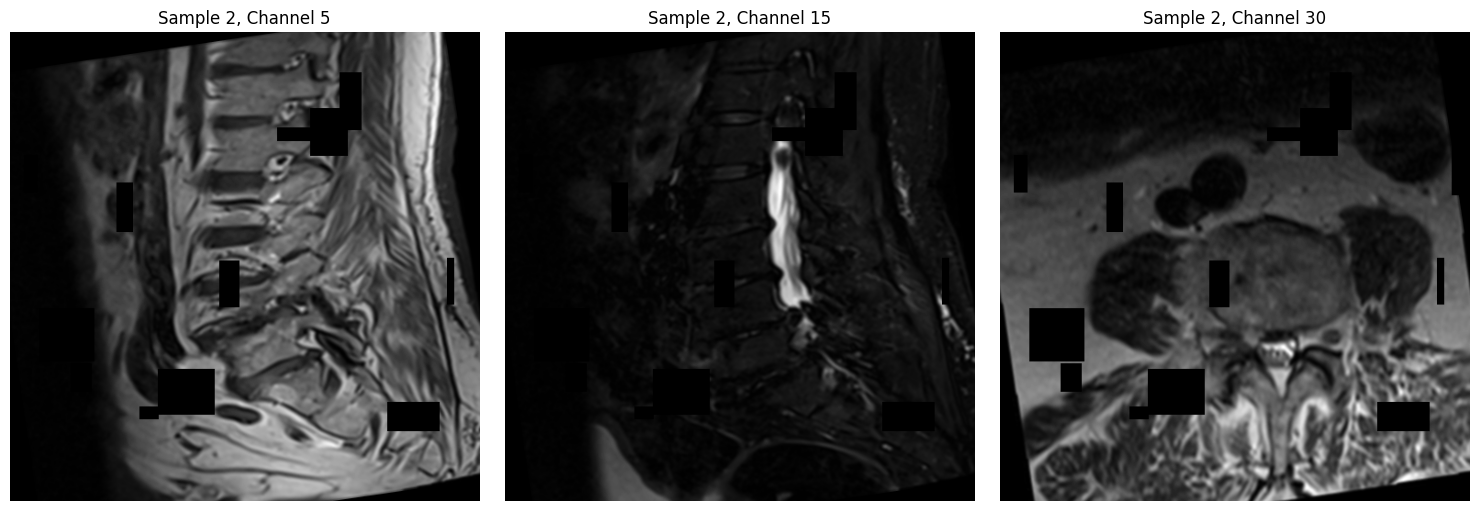

Channel 5 stats - Min: -1.00, Max: 0.96, Mean: -0.53, Std: 0.40
Channel 15 stats - Min: -1.00, Max: 0.97, Mean: -0.88, Std: 0.18
Channel 30 stats - Min: -1.00, Max: 0.95, Mean: -0.63, Std: 0.34



In [14]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
    tmp_ds,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0
)

def display_channel(input_tensor, channel, title):
    channel_image = input_tensor[0, channel].numpy()
    channel_image = (channel_image - channel_image.min()) / (channel_image.max() - channel_image.min())
    plt.imshow(channel_image, cmap='gray')
    plt.title(title)
    plt.axis('off')

for i, (input_tensor, target) in enumerate(tmp_dl):
    if i == 2:
        break

    print(f"Sample {i+1}:")
    print(f"Input tensor shape: {input_tensor.shape}")
    print(f"Input tensor stats - Min: {input_tensor.min():.2f}, Max: {input_tensor.max():.2f}, Mean: {input_tensor.mean():.2f}, Std: {input_tensor.std():.2f}")
    print(f"Target: {target}, Shape: {target.shape}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    display_channel(input_tensor, 5, f"Sample {i+1}, Channel 5")

    plt.subplot(1, 3, 2)
    display_channel(input_tensor, 15, f"Sample {i+1}, Channel 15")

    plt.subplot(1, 3, 3)
    display_channel(input_tensor, 30, f"Sample {i+1}, Channel 30")

    plt.tight_layout()
    plt.show()

    print(f"Channel 5 stats - Min: {input_tensor[0, 5].min():.2f}, Max: {input_tensor[0, 5].max():.2f}, Mean: {input_tensor[0, 5].mean():.2f}, Std: {input_tensor[0, 5].std():.2f}")
    print(f"Channel 15 stats - Min: {input_tensor[0, 15].min():.2f}, Max: {input_tensor[0, 15].max():.2f}, Mean: {input_tensor[0, 15].mean():.2f}, Std: {input_tensor[0, 15].std():.2f}")
    print(f"Channel 30 stats - Min: {input_tensor[0, 30].min():.2f}, Max: {input_tensor[0, 30].max():.2f}, Mean: {input_tensor[0, 30].mean():.2f}, Std: {input_tensor[0, 30].std():.2f}")
    print()

plt.close()
del tmp_ds, tmp_dl

In [15]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=40, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained,
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )

    def forward(self, x):
        y = self.model(x)
        return y

In [16]:
m = RSNA24Model(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, 512, 512)
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

del m, i, out

torch.Size([75]) tensor(-0.9332, grad_fn=<MinBackward1>) tensor(0.9432, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-0.9203, grad_fn=<MinBackward1>) tensor(0.9683, grad_fn=<MaxBackward1>)


In [18]:
# Setup automatic mixed precision (AMP) for faster training and reduced memory usage
# autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # for newer Ampere GPUs
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # for T4 or newer GPUs
# Initialize gradient scaler for AMP
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

# Setup K-Fold cross-validation
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    # Create training dataset and dataloader
    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    # Create validation dataset and dataloader
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=BATCH_SIZE,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    # Initialize the model
    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)

    # Setup optimizer
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    # Setup learning rate scheduler with warmup
    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=num_total_steps,
                                                num_cycles=num_cycles)

    # Setup weighted loss function
    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    criterion2 = nn.CrossEntropyLoss(weight=weights)

    best_loss = 1.2
    best_wll = 1.2
    es_step = 0

    # Training loop
    for epoch in range(1, EPOCHS+1):
        print(f'start epoch {epoch}')
        model.train()
        total_loss = 0
        with tqdm(train_dl, leave=True) as pbar:
            optimizer.zero_grad()
            for idx, (x, t) in enumerate(pbar):
                x = x.to(device)
                t = t.to(device)

                with autocast:
                    loss = 0
                    y = model(x)
                    # Calculate loss for each label
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        loss = loss + criterion(pred, gt) / N_LABELS

                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss = loss / GRAD_ACC

                # Check for NaN loss
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)

                # Update progress bar
                pbar.set_postfix(
                    OrderedDict(
                        loss=f'{loss.item()*GRAD_ACC:.6f}',
                        lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                    )
                )
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                # Gradient accumulation step
                if (idx + 1) % GRAD_ACC == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if scheduler is not None:
                        scheduler.step()

        train_loss = total_loss/len(train_dl)
        print(f'train_loss:{train_loss:.6f}')

        # Validation loop
        total_loss = 0
        y_preds = []
        labels = []

        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):

                    x = x.to(device)
                    t = t.to(device)

                    with autocast:
                        loss = 0
                        loss_ema = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]

                            loss = loss + criterion(pred, gt) / N_LABELS
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())

                        total_loss += loss.item()

        val_loss = total_loss/len(valid_dl)

        # Calculate validation metrics
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = criterion2(y_preds, labels)

        print(f'val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')

        # Save best model and update best scores
        if val_loss < best_loss or val_wll < best_wll:

            es_step = 0

            if device!='cuda:0':
                model.to('cuda:0')

            if val_loss < best_loss:
                print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss
                
            output_dir = f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models'
            os.makedirs(output_dir, exist_ok=True)

            if val_wll < best_wll:
                print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                fname = os.path.join(output_dir, f'best_wll_model_fold-{fold}.pt')
                torch.save(model.state_dict(), fname)

            if device!='cuda:0':
                model.to(device)

        else:
            # Early stopping logic
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('early stopping')
                break

##############################
start fold0
##############################
1577 395


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

start epoch 1


100%|██████████| 98/98 [06:56<00:00,  4.25s/it, loss=0.792187, lr=9.796e-05]


train_loss:0.995302


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


val_loss:0.826935, val_wll:0.880804
epoch:1, best loss updated from 1.200000 to 0.826935
epoch:1, best wll_metric updated from 1.200000 to 0.880804
start epoch 2


100%|██████████| 98/98 [06:10<00:00,  3.79s/it, loss=0.703474, lr=1.980e-04]


train_loss:0.757948


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.725903, val_wll:0.775687
epoch:2, best loss updated from 0.826935 to 0.725903
epoch:2, best wll_metric updated from 0.880804 to 0.775687
start epoch 3


100%|██████████| 98/98 [06:02<00:00,  3.70s/it, loss=0.613943, lr=1.987e-04]


train_loss:0.701062


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.681179, val_wll:0.733477
epoch:3, best loss updated from 0.725903 to 0.681179
epoch:3, best wll_metric updated from 0.775687 to 0.733477
start epoch 4


100%|██████████| 98/98 [06:19<00:00,  3.87s/it, loss=0.731310, lr=1.947e-04]


train_loss:0.660930


100%|██████████| 25/25 [00:53<00:00,  2.16s/it]


val_loss:0.681299, val_wll:0.728204
epoch:4, best wll_metric updated from 0.733477 to 0.728204
start epoch 5


100%|██████████| 98/98 [06:17<00:00,  3.85s/it, loss=0.661474, lr=1.880e-04]


train_loss:0.633956


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.665339, val_wll:0.712660
epoch:5, best loss updated from 0.681179 to 0.665339
epoch:5, best wll_metric updated from 0.728204 to 0.712660
start epoch 6


100%|██████████| 98/98 [06:16<00:00,  3.84s/it, loss=0.645623, lr=1.790e-04]


train_loss:0.615310


100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


val_loss:0.661353, val_wll:0.710548
epoch:6, best loss updated from 0.665339 to 0.661353
epoch:6, best wll_metric updated from 0.712660 to 0.710548
start epoch 7


100%|██████████| 98/98 [06:06<00:00,  3.74s/it, loss=0.699577, lr=1.678e-04]


train_loss:0.597063


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.641133, val_wll:0.689833
epoch:7, best loss updated from 0.661353 to 0.641133
epoch:7, best wll_metric updated from 0.710548 to 0.689833
start epoch 8


100%|██████████| 98/98 [06:09<00:00,  3.77s/it, loss=0.674193, lr=1.547e-04]


train_loss:0.580009


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


val_loss:0.648525, val_wll:0.701368
start epoch 9


100%|██████████| 98/98 [06:11<00:00,  3.79s/it, loss=0.606534, lr=1.402e-04]


train_loss:0.564312


100%|██████████| 25/25 [00:53<00:00,  2.12s/it]


val_loss:0.649254, val_wll:0.700463
start epoch 10


100%|██████████| 98/98 [06:03<00:00,  3.70s/it, loss=0.545979, lr=1.245e-04]


train_loss:0.543967


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.649022, val_wll:0.700916
early stopping
##############################
start fold1
##############################
1577 395
start epoch 1


100%|██████████| 98/98 [06:02<00:00,  3.70s/it, loss=0.810901, lr=9.796e-05]


train_loss:0.999846


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.796702, val_wll:0.860787
epoch:1, best loss updated from 1.200000 to 0.796702
epoch:1, best wll_metric updated from 1.200000 to 0.860787
start epoch 2


100%|██████████| 98/98 [06:01<00:00,  3.69s/it, loss=0.808488, lr=1.980e-04]


train_loss:0.770172


100%|██████████| 25/25 [00:50<00:00,  2.00s/it]


val_loss:0.691360, val_wll:0.760755
epoch:2, best loss updated from 0.796702 to 0.691360
epoch:2, best wll_metric updated from 0.860787 to 0.760755
start epoch 3


100%|██████████| 98/98 [06:05<00:00,  3.73s/it, loss=0.569098, lr=1.987e-04]


train_loss:0.706084


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.719784, val_wll:0.770868
start epoch 4


100%|██████████| 98/98 [06:06<00:00,  3.74s/it, loss=0.787504, lr=1.947e-04]


train_loss:0.668616


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.642535, val_wll:0.704821
epoch:4, best loss updated from 0.691360 to 0.642535
epoch:4, best wll_metric updated from 0.760755 to 0.704821
start epoch 5


100%|██████████| 98/98 [06:00<00:00,  3.68s/it, loss=0.609695, lr=1.880e-04]


train_loss:0.644550


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.637033, val_wll:0.689939
epoch:5, best loss updated from 0.642535 to 0.637033
epoch:5, best wll_metric updated from 0.704821 to 0.689939
start epoch 6


100%|██████████| 98/98 [06:04<00:00,  3.72s/it, loss=0.563207, lr=1.790e-04]


train_loss:0.632352


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.618189, val_wll:0.679630
epoch:6, best loss updated from 0.637033 to 0.618189
epoch:6, best wll_metric updated from 0.689939 to 0.679630
start epoch 7


100%|██████████| 98/98 [06:03<00:00,  3.71s/it, loss=0.721597, lr=1.678e-04]


train_loss:0.604078


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


val_loss:0.626583, val_wll:0.691979
start epoch 8


100%|██████████| 98/98 [06:15<00:00,  3.83s/it, loss=0.555246, lr=1.547e-04]


train_loss:0.592036


100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


val_loss:0.614378, val_wll:0.674641
epoch:8, best loss updated from 0.618189 to 0.614378
epoch:8, best wll_metric updated from 0.679630 to 0.674641
start epoch 9


100%|██████████| 98/98 [06:02<00:00,  3.70s/it, loss=0.457121, lr=1.402e-04]


train_loss:0.573829


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.617896, val_wll:0.682462
start epoch 10


100%|██████████| 98/98 [06:08<00:00,  3.76s/it, loss=0.593174, lr=1.245e-04]


train_loss:0.556893


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


val_loss:0.614468, val_wll:0.677754
start epoch 11


100%|██████████| 98/98 [06:10<00:00,  3.78s/it, loss=0.591583, lr=1.082e-04]


train_loss:0.539290


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


val_loss:0.617527, val_wll:0.674054
epoch:11, best wll_metric updated from 0.674641 to 0.674054
start epoch 12


100%|██████████| 98/98 [05:59<00:00,  3.67s/it, loss=0.581171, lr=9.162e-05]


train_loss:0.521118


100%|██████████| 25/25 [00:51<00:00,  2.04s/it]


val_loss:0.621335, val_wll:0.683734
start epoch 13


100%|██████████| 98/98 [06:08<00:00,  3.76s/it, loss=0.401158, lr=7.529e-05]


train_loss:0.506804


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


val_loss:0.623861, val_wll:0.686288
start epoch 14


100%|██████████| 98/98 [06:09<00:00,  3.77s/it, loss=0.518166, lr=5.964e-05]


train_loss:0.492327


100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


val_loss:0.636996, val_wll:0.706421
early stopping
##############################
start fold2
##############################
1578 394
start epoch 1


100%|██████████| 98/98 [06:07<00:00,  3.75s/it, loss=0.832061, lr=9.796e-05]


train_loss:1.013539


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


val_loss:0.809735, val_wll:0.876024
epoch:1, best loss updated from 1.200000 to 0.809735
epoch:1, best wll_metric updated from 1.200000 to 0.876024
start epoch 2


100%|██████████| 98/98 [06:01<00:00,  3.69s/it, loss=0.597926, lr=1.980e-04]


train_loss:0.763499


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.751006, val_wll:0.806402
epoch:2, best loss updated from 0.809735 to 0.751006
epoch:2, best wll_metric updated from 0.876024 to 0.806402
start epoch 3


100%|██████████| 98/98 [06:19<00:00,  3.87s/it, loss=0.892578, lr=1.987e-04]


train_loss:0.699769


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.689374, val_wll:0.743957
epoch:3, best loss updated from 0.751006 to 0.689374
epoch:3, best wll_metric updated from 0.806402 to 0.743957
start epoch 4


100%|██████████| 98/98 [06:06<00:00,  3.74s/it, loss=0.677371, lr=1.947e-04]


train_loss:0.663699


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.645050, val_wll:0.709773
epoch:4, best loss updated from 0.689374 to 0.645050
epoch:4, best wll_metric updated from 0.743957 to 0.709773
start epoch 5


100%|██████████| 98/98 [06:18<00:00,  3.86s/it, loss=0.687792, lr=1.880e-04]


train_loss:0.639760


100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


val_loss:0.636662, val_wll:0.701443
epoch:5, best loss updated from 0.645050 to 0.636662
epoch:5, best wll_metric updated from 0.709773 to 0.701443
start epoch 6


100%|██████████| 98/98 [06:31<00:00,  3.99s/it, loss=0.628320, lr=1.790e-04]


train_loss:0.623408


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


val_loss:0.647178, val_wll:0.702984
start epoch 7


100%|██████████| 98/98 [06:29<00:00,  3.98s/it, loss=0.542875, lr=1.678e-04]


train_loss:0.602150


100%|██████████| 25/25 [00:53<00:00,  2.16s/it]


val_loss:0.629529, val_wll:0.696823
epoch:7, best loss updated from 0.636662 to 0.629529
epoch:7, best wll_metric updated from 0.701443 to 0.696823
start epoch 8


100%|██████████| 98/98 [06:09<00:00,  3.77s/it, loss=0.565592, lr=1.547e-04]


train_loss:0.589023


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


val_loss:0.627803, val_wll:0.692753
epoch:8, best loss updated from 0.629529 to 0.627803
epoch:8, best wll_metric updated from 0.696823 to 0.692753
start epoch 9


100%|██████████| 98/98 [06:22<00:00,  3.91s/it, loss=0.536627, lr=1.402e-04]


train_loss:0.564342


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.612667, val_wll:0.671845
epoch:9, best loss updated from 0.627803 to 0.612667
epoch:9, best wll_metric updated from 0.692753 to 0.671845
start epoch 10


100%|██████████| 98/98 [06:05<00:00,  3.73s/it, loss=0.456153, lr=1.245e-04]


train_loss:0.548455


100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


val_loss:0.616125, val_wll:0.675326
start epoch 11


100%|██████████| 98/98 [06:05<00:00,  3.73s/it, loss=0.516774, lr=1.082e-04]


train_loss:0.530190


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


val_loss:0.620106, val_wll:0.681641
start epoch 12


100%|██████████| 98/98 [06:03<00:00,  3.71s/it, loss=0.602776, lr=9.162e-05]


train_loss:0.515233


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


val_loss:0.625310, val_wll:0.687508
early stopping
##############################
start fold3
##############################
1578 394
start epoch 1


100%|██████████| 98/98 [06:01<00:00,  3.69s/it, loss=0.822760, lr=9.796e-05]


train_loss:1.017088


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.809128, val_wll:0.866450
epoch:1, best loss updated from 1.200000 to 0.809128
epoch:1, best wll_metric updated from 1.200000 to 0.866450
start epoch 2


100%|██████████| 98/98 [06:02<00:00,  3.70s/it, loss=0.885618, lr=1.980e-04]


train_loss:0.775431


100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


val_loss:0.724036, val_wll:0.780669
epoch:2, best loss updated from 0.809128 to 0.724036
epoch:2, best wll_metric updated from 0.866450 to 0.780669
start epoch 3


100%|██████████| 98/98 [05:56<00:00,  3.63s/it, loss=0.962298, lr=1.987e-04]


train_loss:0.715686


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


val_loss:0.677085, val_wll:0.729689
epoch:3, best loss updated from 0.724036 to 0.677085
epoch:3, best wll_metric updated from 0.780669 to 0.729689
start epoch 4


100%|██████████| 98/98 [06:02<00:00,  3.70s/it, loss=0.531606, lr=1.947e-04]


train_loss:0.674059


100%|██████████| 25/25 [00:50<00:00,  2.00s/it]


val_loss:0.652706, val_wll:0.702047
epoch:4, best loss updated from 0.677085 to 0.652706
epoch:4, best wll_metric updated from 0.729689 to 0.702047
start epoch 5


100%|██████████| 98/98 [06:04<00:00,  3.72s/it, loss=0.740764, lr=1.880e-04]


train_loss:0.653880


100%|██████████| 25/25 [00:51<00:00,  2.04s/it]


val_loss:0.623507, val_wll:0.678691
epoch:5, best loss updated from 0.652706 to 0.623507
epoch:5, best wll_metric updated from 0.702047 to 0.678691
start epoch 6


100%|██████████| 98/98 [06:07<00:00,  3.75s/it, loss=0.595222, lr=1.790e-04]


train_loss:0.630814


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.610434, val_wll:0.663258
epoch:6, best loss updated from 0.623507 to 0.610434
epoch:6, best wll_metric updated from 0.678691 to 0.663258
start epoch 7


100%|██████████| 98/98 [06:12<00:00,  3.80s/it, loss=0.578391, lr=1.678e-04]


train_loss:0.612120


100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


val_loss:0.608328, val_wll:0.662844
epoch:7, best loss updated from 0.610434 to 0.608328
epoch:7, best wll_metric updated from 0.663258 to 0.662844
start epoch 8


100%|██████████| 98/98 [06:03<00:00,  3.71s/it, loss=0.593408, lr=1.547e-04]


train_loss:0.593128


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


val_loss:0.606985, val_wll:0.656687
epoch:8, best loss updated from 0.608328 to 0.606985
epoch:8, best wll_metric updated from 0.662844 to 0.656687
start epoch 9


100%|██████████| 98/98 [06:02<00:00,  3.70s/it, loss=0.414597, lr=1.402e-04]


train_loss:0.582529


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.602002, val_wll:0.652603
epoch:9, best loss updated from 0.606985 to 0.602002
epoch:9, best wll_metric updated from 0.656687 to 0.652603
start epoch 10


100%|██████████| 98/98 [05:55<00:00,  3.63s/it, loss=0.594762, lr=1.245e-04]


train_loss:0.563735


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.606752, val_wll:0.660542
start epoch 11


100%|██████████| 98/98 [06:04<00:00,  3.72s/it, loss=0.563107, lr=1.082e-04]


train_loss:0.542042


100%|██████████| 25/25 [00:51<00:00,  2.04s/it]


val_loss:0.613001, val_wll:0.663236
start epoch 12


100%|██████████| 98/98 [06:05<00:00,  3.73s/it, loss=0.564513, lr=9.162e-05]


train_loss:0.529730


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


val_loss:0.619540, val_wll:0.672037
early stopping
##############################
start fold4
##############################
1578 394
start epoch 1


100%|██████████| 98/98 [05:55<00:00,  3.63s/it, loss=0.873017, lr=9.796e-05]


train_loss:1.026308


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.792427, val_wll:0.863401
epoch:1, best loss updated from 1.200000 to 0.792427
epoch:1, best wll_metric updated from 1.200000 to 0.863401
start epoch 2


100%|██████████| 98/98 [06:03<00:00,  3.71s/it, loss=0.734720, lr=1.980e-04]


train_loss:0.775013


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


val_loss:0.708334, val_wll:0.777588
epoch:2, best loss updated from 0.792427 to 0.708334
epoch:2, best wll_metric updated from 0.863401 to 0.777588
start epoch 3


100%|██████████| 98/98 [06:02<00:00,  3.70s/it, loss=0.739343, lr=1.987e-04]


train_loss:0.713546


100%|██████████| 25/25 [00:51<00:00,  2.04s/it]


val_loss:0.667678, val_wll:0.731364
epoch:3, best loss updated from 0.708334 to 0.667678
epoch:3, best wll_metric updated from 0.777588 to 0.731364
start epoch 4


100%|██████████| 98/98 [06:02<00:00,  3.70s/it, loss=0.691102, lr=1.947e-04]


train_loss:0.674661


100%|██████████| 25/25 [00:51<00:00,  2.04s/it]


val_loss:0.690323, val_wll:0.745939
start epoch 5


100%|██████████| 98/98 [06:03<00:00,  3.70s/it, loss=0.763112, lr=1.880e-04]


train_loss:0.641422


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.640430, val_wll:0.699048
epoch:5, best loss updated from 0.667678 to 0.640430
epoch:5, best wll_metric updated from 0.731364 to 0.699048
start epoch 6


100%|██████████| 98/98 [06:04<00:00,  3.72s/it, loss=0.570297, lr=1.790e-04]


train_loss:0.623755


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.639613, val_wll:0.703059
epoch:6, best loss updated from 0.640430 to 0.639613
start epoch 7


100%|██████████| 98/98 [06:01<00:00,  3.69s/it, loss=0.724070, lr=1.678e-04]


train_loss:0.603997


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.632364, val_wll:0.696228
epoch:7, best loss updated from 0.639613 to 0.632364
epoch:7, best wll_metric updated from 0.699048 to 0.696228
start epoch 8


100%|██████████| 98/98 [05:58<00:00,  3.66s/it, loss=0.513831, lr=1.547e-04]


train_loss:0.589824


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.624383, val_wll:0.684888
epoch:8, best loss updated from 0.632364 to 0.624383
epoch:8, best wll_metric updated from 0.696228 to 0.684888
start epoch 9


100%|██████████| 98/98 [06:00<00:00,  3.68s/it, loss=0.665868, lr=1.402e-04]


train_loss:0.571340


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


val_loss:0.629340, val_wll:0.692452
start epoch 10


100%|██████████| 98/98 [06:26<00:00,  3.94s/it, loss=0.458733, lr=1.245e-04]


train_loss:0.559079


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


val_loss:0.618063, val_wll:0.678371
epoch:10, best loss updated from 0.624383 to 0.618063
epoch:10, best wll_metric updated from 0.684888 to 0.678371
start epoch 11


100%|██████████| 98/98 [06:54<00:00,  4.23s/it, loss=0.546628, lr=1.082e-04]


train_loss:0.536509


100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


val_loss:0.644961, val_wll:0.715798
start epoch 12


100%|██████████| 98/98 [06:12<00:00,  3.80s/it, loss=0.606490, lr=9.162e-05]


train_loss:0.518227


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.630096, val_wll:0.691497
start epoch 13


100%|██████████| 98/98 [06:13<00:00,  3.81s/it, loss=0.395336, lr=7.529e-05]


train_loss:0.506861


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]

val_loss:0.643767, val_wll:0.708973
early stopping


In [19]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    df_valid = df.iloc[val_idx]
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
    fname = f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/best_wll_model_fold-{fold}.pt'
    model.load_state_dict(torch.load(fname))
    model.to(device)   
    
    model.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):
                
                x = x.to(device)
                t = t.to(device)
                    
                with autocast:
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col] 
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

cv = criterion2(y_preds, labels)
print('cv score:', cv.item())

##############################
start fold0
##############################


100%|██████████| 395/395 [00:54<00:00,  7.22it/s]


##############################
start fold1
##############################


100%|██████████| 395/395 [00:52<00:00,  7.51it/s]


##############################
start fold2
##############################


100%|██████████| 394/394 [00:52<00:00,  7.53it/s]


##############################
start fold3
##############################


100%|██████████| 394/394 [00:52<00:00,  7.53it/s]


##############################
start fold4
##############################


100%|██████████| 394/394 [00:52<00:00,  7.53it/s]


cv score: 0.6734185218811035


In [20]:
from sklearn.metrics import log_loss
y_pred_np = y_preds.softmax(1).numpy()
labels_np = labels.numpy()
y_pred_nan = np.zeros((y_preds.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(labels, y_pred2, normalize=True, sample_weight=weights)
print('cv score:', cv2)

cv score: 0.6734185519278487


In [21]:
np.save(f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/labels.npy', labels_np)
np.save(f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/final_oof.npy', y_pred2)